# Models
In this notebook we will generate several different models using the already engineered features. We will then evaluate the models using cross validation and select the best model to use for our predictions.

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [13]:
GEO = 'texas_florida'
df = pd.read_csv(f'../../data/processed/features_{GEO}.csv')
df.index = df["review_id"]
df.drop(columns=["review_id"], inplace=True)

print(df.shape)
df.head()

(1629, 101)


,tsne2_comments_2D_0,tsne2_comments_2D_1,tsne3_comments_3D_0,tsne3_comments_3D_1,tsne3_comments_3D_2,tsne2_description_2D_0,tsne2_description_2D_1,tsne3_description_3D_0,tsne3_description_3D_1,tsne3_description_3D_2,...,amenityall_dishwasher,amenityall_silverware,amenityall_bathtub,amenityall_lockbox,amenityall_crib,amenityall_elevator,amenityall_gym,amenityall_oven,amenityall_toilet,label
review_id,,,,,,,,,,,,,,,,,,,,,
83097,44.797146,-91.826430,19.198887,-34.306694,-12.887021,44.797146,-91.826430,19.198887,-34.306694,-12.887021,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,good
133337,44.797146,-91.826430,20.718470,-30.874128,-17.147860,44.797146,-91.826430,20.718470,-30.874128,-17.147860,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,good
150928,46.442818,-96.150764,23.746138,-35.620407,-16.147621,46.442818,-96.150764,23.746138,-35.620407,-16.147621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,good
2706775,46.442818,-96.150764,23.746138,-35.620407,-16.147621,46.442818,-96.150764,23.746138,-35.620407,-16.147621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,good
8602878,46.442818,-96.150764,23.746138,-35.620407,-16.147621,46.442818,-96.150764,23.746138,-35.620407,-16.147621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,good


In [14]:
df.label.value_counts()

good     1320
mbad      118
mgood     105
bad        84
Name: label, dtype: int64

Drop NA labels... THANKS Charlie :/

In [15]:
df = df.dropna()

The data is extremely imbalanced. We can use the `imbalanced-learn` Python library, which has several implementations of resampling methods to deal with this problem. We will use the `SMOTE` method, which oversamples the minority class.

In [16]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X, y = oversample.fit_resample(df.drop(columns=["label"]), df["label"])

print("Balanced labels:")
y.value_counts()

Balanced labels:


good     1320
mgood    1320
mbad     1320
bad      1320
Name: label, dtype: int64

## Testing out different feature combinations
We want to try the different combinations of features to see which ones work best.

In [17]:
import itertools

feature_sets = [
    "tsne2_comments_2D_",
    "tsne3_comments_3D_",
    "tsne2_description_2D_",
    "tsne3_description_3D_",
    "3gram09_",
    "3gram10_",
    "amenity005_",
    "amenityall_"
]

# get all combinations of feature sets of all lengths
feature_sets_combinations = []
for i in range(1, len(feature_sets) + 1):
    feature_sets_combinations += [list(x) for x in itertools.combinations(feature_sets, i)]

print(f"Number of feature sets combinations: {len(feature_sets_combinations)}")

Number of feature sets combinations: 255


In [ ]:
from lazypredict.Supervised import LazyClassifier

top_models = {}
best_model = None
best_accuracy = -1
best_feature_set = None

num_of_feature_sets_combinations = len(feature_sets_combinations)

for i, feature_sets_combination in enumerate(feature_sets_combinations):

    print(f"Testing feature sets combination {i + 1} of {num_of_feature_sets_combinations} ({feature_sets_combination})")

    # get column subset
    df_subset_columns = [c for c in df.columns if any([c.startswith(f) for f in feature_sets_combination])]
    df_subset_columns.append("label")

    # oversample and get train/test split
    df_subset = df[df_subset_columns]
    X, y = oversample.fit_resample(df_subset.drop(columns=["label"]), df_subset["label"])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # train model
    clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
    models, predictions = clf.fit(X_train, X_test, y_train, y_test)
    top_models_for_subset = models.sort_values(by="Accuracy", ascending=False).head(10)

    top_model = models.iloc[0]
    accuracy = top_model["Accuracy"]
    name = top_model.name
    print(f"Top model for {feature_sets_combination}: {name}. Accuracy = {accuracy}")
    if top_model["Accuracy"] > best_accuracy:
        best_accuracy = top_model["Accuracy"]
        best_model = top_model
        best_feature_set = feature_sets_combination
        print(f"New best model found! Accuracy = {accuracy}")

    # save results
    top_models[",".join(feature_sets_combination)] = top_models_for_subset

    print()


print(f"Best model: {best_model.name} with feature set {best_feature_set}\nAccuracy = {best_accuracy}")

import pickle
# save top_models
with open(f"../../data/processed/top_models_{GEO}.pickle", "wb") as f:
    pickle.dump(top_models, f)

In [18]:
import pickle
top_models = pickle.load(open(f"top_models_{GEO}.pickle", "rb"))

report = []

feature_set_to_letter = {
    "tsne2_description_2D_": "(A)",
    "tsne3_description_3D_" : "(B)",
    "tsne2_comments_2D_" : "(C)",
    "tsne3_comments_3D_" : "(D)",
    "3gram09_" : "(E)",
    "3gram10_" : "(F)",
    "amenity005_" : "(G)",
    "amenityall_" : "(H)"
}

# iterate over keys and values
for key, value in top_models.items():
    top_model_name = value.iloc[0].name
    top_model_accuracy = value.iloc[0]["Accuracy"]

    report.append({
        "feature_set": ", ".join([feature_set_to_letter[f] for f in key.split(",")]),
        "top_model_name": top_model_name,
        "top_model_accuracy": top_model_accuracy
    })

top = pd.DataFrame(report).sort_values(by="top_model_accuracy", ascending=False)
top.head(10)

,feature_set,top_model_name,top_model_accuracy
208,"(D), (B), (E), (F), (H)",ExtraTreesClassifier,0.935606
230,"(C), (D), (B), (E), (G), (H)",ExtraTreesClassifier,0.928977
179,"(C), (D), (E), (F), (H)",ExtraTreesClassifier,0.928030
149,"(A), (B), (E), (H)",ExtraTreesClassifier,0.928030
84,"(B), (E), (H)",ExtraTreesClassifier,0.927083
253,"(D), (A), (B), (E), (F), (G), (H)",ExtraTreesClassifier,0.926136
199,"(D), (A), (B), (E), (H)",ExtraTreesClassifier,0.926136
141,"(D), (B), (F), (H)",ExtraTreesClassifier,0.926136
229,"(C), (D), (B), (E), (F), (H)",ExtraTreesClassifier,0.925189
105,"(C), (D), (F), (H)",ExtraTreesClassifier,0.925189


Let's see which features appear the most in models that perform over 80% accuracy.

There are 101 models above 90% accuracy


<AxesSubplot: xlabel='% of top models using feature set', ylabel='Feature set'>

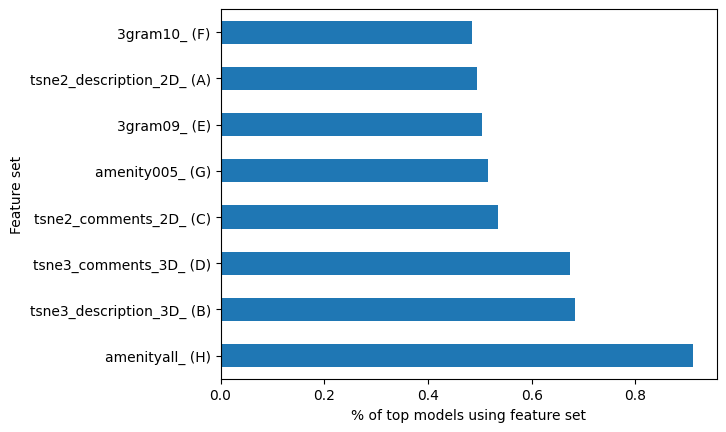

In [19]:
# split feature_set into individual feature sets
letters = ["(A)", "(B)", "(C)", "(D)", "(E)", "(F)", "(G)", "(H)"]
top["feature_set_split"] = top["feature_set"].apply(lambda x: x.split(", "))
for letter in ["(A)", "(B)", "(C)", "(D)", "(E)", "(F)", "(G)", "(H)"]:
    top[letter] = top["feature_set_split"].apply(lambda x: letter in x)

# lets see what percent of the top models have each feature set (top models will be above 80% accuracy)
with_accuracy = top[["top_model_accuracy"] + letters]
models_above_90_accuracy = with_accuracy[with_accuracy.top_model_accuracy > 0.9]
print(f"There are {models_above_90_accuracy.shape[0]} models above 90% accuracy")
feature_set_distr = models_above_90_accuracy.sum().drop("top_model_accuracy").sort_values(ascending=False) / models_above_90_accuracy.shape[0]


# convert back to feature set name
# reverse feature_set_to_letter
feature_set_to_letter = {v: k for k, v in feature_set_to_letter.items()}
feature_set_distr.index = feature_set_distr.index.map(lambda x: feature_set_to_letter[x] + " " + x)
feature_set_distr.plot(kind="barh", xlabel="% of top models using feature set", ylabel="Feature set")

Let's grab the best subset, and hyperparameter tune the best model!

In [20]:
top_feature_set = top.reset_index().iloc[0].feature_set.split(", ")
top_feature_set = [feature_set_to_letter[f] for f in top_feature_set]
top_feature_set

['tsne3_comments_3D_',
 'tsne3_description_3D_',
 '3gram09_',
 '3gram10_',
 'amenityall_']

In [21]:
columns_in_best_feature_set = [c for c in df.columns if any([c.startswith(f) for f in top_feature_set])]
columns_in_best_feature_set.append("label")

df_best_subset = df[columns_in_best_feature_set]

print("Best feature set:")
print(columns_in_best_feature_set)


Best feature set:
['tsne3_comments_3D_0', 'tsne3_comments_3D_1', 'tsne3_comments_3D_2', 'tsne3_description_3D_0', 'tsne3_description_3D_1', 'tsne3_description_3D_2', '3gram09_would_not_recommend', '3gram09_no_toilet_paper', '3gram09_not_recommend_staying', '3gram09_per_night_not', '3gram09_could_not_access', '3gram09_phone_call_text', '3gram09_very_old_not', '3gram09_call_text_message', '3gram09_left_first_night', '3gram09_old_not_well', '3gram09_worse_experience_ever', '3gram09_paid_two_night', '3gram09_refund_second_night', '3gram09_expected_based_description', '3gram09_not_really_clean', '3gram09_need_deep_cleaning', '3gram09_got_no_response', '3gram09_toilet_paper_buy', '3gram09_never_met_host', '3gram09_property_management_company', '3gram09_nothing_like_picture', '3gram09_freezer_not_work', '3gram09_obviously_not_cleaned', '3gram09_shower_curtain_covered', '3gram09_never_responded_message', '3gram09_not_clean_arrived', '3gram09_not_feel_comfortable', '3gram09_very_bad_shape', '3g

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters:
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 0.93


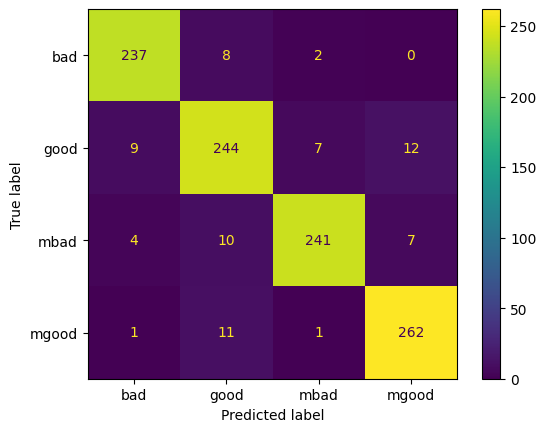

In [22]:
# load ExtraTreesClassifier
from sklearn.ensemble import ExtraTreesClassifier

# apply GridSearchCV to find the best parameters
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['auto', 'sqrt', 'log2'],
}

clf = GridSearchCV(ExtraTreesClassifier(), params, cv=5, n_jobs=-1, verbose=1)

# oversample and get train/test split
X, y = oversample.fit_resample(df_best_subset.drop(columns=["label"]), df_best_subset["label"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf.fit(X_train, y_train)
best_clf = clf.best_estimator_

# print the best parameters
print("Best parameters:")
print(clf.best_params_)

# predict
y_pred = best_clf.predict(X_test)

# evaluate
from sklearn.metrics import accuracy_score

print("Accuracy:", round(accuracy_score(y_test, y_pred), 2))

# plot a confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

# Save the model along with functions to generate features

In [32]:
pickle.dump({
    "best_clf": best_clf,
    "best_feature_set": columns_in_best_feature_set,
}, open(f"best_clf_{GEO}.pickle", "wb"))